# 1. Abstract

*As data science methods continue their interdisciplinary diffusion to a wide range of research disciplines across higher education (including the humanities and social sciences), universities need to likewise develop data-driven methods to better understand the diversity of their course offerings, to analyze potential redundancies and overlaps in course content, and to assist students in making well-informed decisions for elective choices and plans of study. In recent years, the field of Educational Data Mining (EDM) has coalesced as data-driven tools and techniques are applied to curricular content, allowing institutions to make use of the data contained in course descriptions, syllabi, and learning management systems. This article focuses on course descriptions only at this time, and contributes to EDM by seeking to understanding the relationship between marketplace offerings through indeed, and curriculum design.*

*Most people who do this have stopped at LDA, and we go beyond that by analyzing whether the topics group or coalesce into higher level domains.*

*In both papers (ALSaad, Jingwen), they’re using external data to compare against, whereas we are using the internal relationships of the content to analyze. We use cosine similarity, a distribution over topic probabilities of two or more vectors.*

*What is the data ecosystem map for each university, based on the courses that are already offered? How can we delineate between non-data courses and data courses? How can we analyze interrelatedness among data science courses?*


In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import nltk.corpus
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud

from gensim.models.ldamodel import LdaModel
import gensim.corpora as corpora
from gensim.utils import simple_preprocess

import pyLDAvis
import pyLDAvis.gensim_models

from pprint import pprint
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.metrics.pairwise import cosine_similarity

# default: plt.rcParams["figure.figsize"] =[6.0, 4.0]
plt.rcParams["figure.figsize"] = (20,12)

In [2]:
df = pd.read_csv('indeed_final.csv')
df_ns = pd.read_csv('nc_state1.csv')

# 2. Data Cleaning

## 2.1 Job Description

After the data collection process, we now have two sets of data to perform our analysis. The data collected from Indeed, and the one collected from the course descriptions from the north Carolina State University's course catalog. As a part of the data cleaning process,

1. First, we converted the text to lower case 
1. Since, this was a raw dump of the job description,
    1. We removed all the email address
    1. Any words starting with digits
    1. Any extra spaces
    1. http tags
    1. all digits
1. Next we removed the stop words. We also included a manual list of redundant words, which were biasing the analysis
1. We lemmatize the words over stemming so that the word is recognizable
1. We took only the words which has at least four chars


In [3]:
def clean_txt(txt):
    txt = txt.replace('\n', ' ').lower()
    txt = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?|\d+", "", txt)
    
    stop = stopwords.words('english')
    stop = stop + ['accomodation', 'accommodation', 'opms', 'oppe', 'employment', 'benefit', 'activity', 'novant', 'preferred', 'within', 'california', 'lincoln', 'ca', 'tx', 'u', 'application', 'may', 'salary', 'working', 'information', 'related', 'including', 'based', 'applicant', 'qualification', 'support', 'provide', 'program', 'bachelor', 'degree', 'employee', 'project', 'service', 'business', 'andor', 'including', 'required', 'position', 'job', 'ability', 'experience', 'work', 'team', 'skill', 'requirement', 'year', 'need', 'ensure', 'position', 'program', 'north', 'carolina', 'education', 'must']
    lemmatizer = WordNetLemmatizer()
    
    txt = " ".join([lemmatizer.lemmatize(word) for word in txt.split() if word not in stop])
    txt = " ".join([word for word in txt.split() if word not in stop and len(word)>3])
    
    return txt

df['desc'] = df.desc.apply(lambda x: clean_txt(str(x)))

## 2.2 Retrieving and binning Salary Information

We got a dump of the salary information too. To extract the salary info,
1. We tried to get the min and max salary range using a regex search and averaged them if yearly, multiplied with $8*30*12$ if hourly and $12$ if monthly.
1. We handled the missing salary with 0.

In [4]:
def make_salary(x):
    rng = 0
    if type(x) == str:
        x = x.replace('\n', '')
        try:
            rng = re.search(r'Salary(.*?) a year', x).group(1).replace('$', '').replace(',', '')
            if '-' in rng:
                rng = (float(rng.split(' - ')[0]) + float(rng.split(' - ')[1]))//2
        except:
            pass
        
        try:
            rng = re.search(r'Salary(.*?) an hour', x).group(1).replace('$', '').replace(',', '')
            if '-' in rng:
                rng = (float(rng.split(' - ')[0]) + float(rng.split(' - ')[1]))//2*8*30*12
        except:
            pass
        
        try:
            rng = re.search(r'Salary(.*?) a month', x).group(1).replace('$', '').replace(',', '')
            if '-' in rng:
                rng = (float(rng.split(' - ')[0]) + float(rng.split(' - ')[1]))//2*12
        except:
            pass
        
    return rng

df['salary_cleaned'] = df.salary.apply(lambda x: make_salary(x))
df['salary_cleaned'] = pd.to_numeric(df.salary_cleaned, errors='coerce')
df['salary_cleaned'] = df['salary_cleaned'].fillna(0)
df.loc[(df.salary_cleaned>0)&(df.salary_cleaned<100), 'salary_cleaned'] = 0

Next, we tried to find the distribution of the Salary information that we just got.

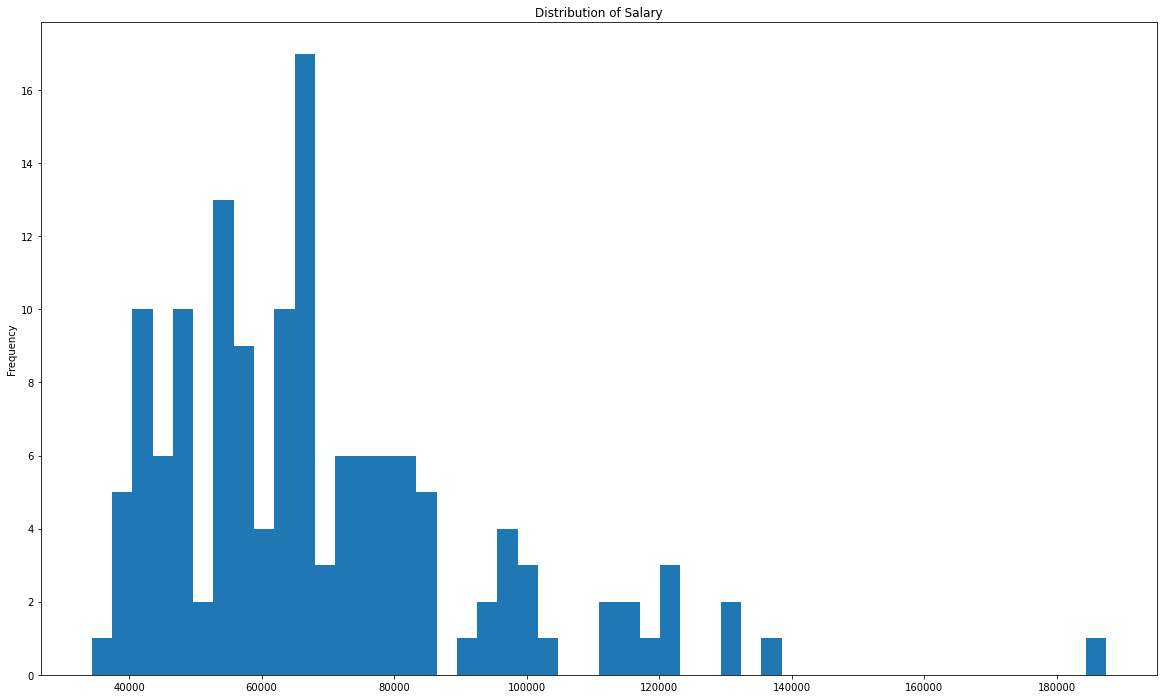

In [5]:
df[df.salary_cleaned>0].salary_cleaned.plot.hist(bins=50)
plt.title('Distribution of Salary')
plt.plot();

We can see a right skew in the distribution which is very natural given it's salary. To analyze things further, we binned the salary into:
1. Low - All jobs which pay between 0 to 50000, fall in this bracket.
1. Mid - All jobs which pay between 50000 to 90000, fall in this bracket.
1. High - All jobs which pay between 90000 to 130000, fall in this bracket.
1. Outliers - All jobs which pay greater than 130000, fall in this bracket.

In [6]:
df.loc[(df.salary_cleaned>0)&(df.salary_cleaned<50000), 'salary_bin'] = 'low'
df.loc[(df.salary_cleaned>50000)&(df.salary_cleaned<90000), 'salary_bin'] = 'mid'
df.loc[(df.salary_cleaned>90000)&(df.salary_cleaned<130000), 'salary_bin'] = 'high'
df.loc[(df.salary_cleaned>130000), 'salary_bin'] = 'outlier'

## 2.3 College Course

In [7]:
def clean_txt_ns(txt):
    txt = txt.replace('\n', ' ').lower()
    txt = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?|\d+", "", txt)
    
    stop = stopwords.words('english')
    stop = stop + ['restrcited', 'include', 'standing', 'corequisite', 'equips', 'practicum', 'master', 'application', 'study', 'topic', 'summer', 'graduate', 'hour', 'credit', 'offered', 'course', 'prerequisite', 'spring', 'typically', 'student', 'fall']
    
    lemmatizer = WordNetLemmatizer()
    txt = " ".join([lemmatizer.lemmatize(word) for word in txt.split() if word not in stop])
    txt = " ".join([word for word in txt.split() if word not in stop and len(word)>3])
    return txt

df_ns['course_content'] = df_ns.course_content.apply(lambda x: clean_txt_ns(str(x)))

# 3. Visualizing the WordClouds of the salary bins

The next process is to visualize the WordClouds of the salary bins

In [8]:
def make_wordcloud(txt, title):
    wc = WordCloud(background_color='white', width=1920, height=1080, collocations=False)
    wc.generate_from_text(txt)

    plt.figure(figsize=[15, 15])
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'{title}\n\n', fontsize=30)
    plt.show()

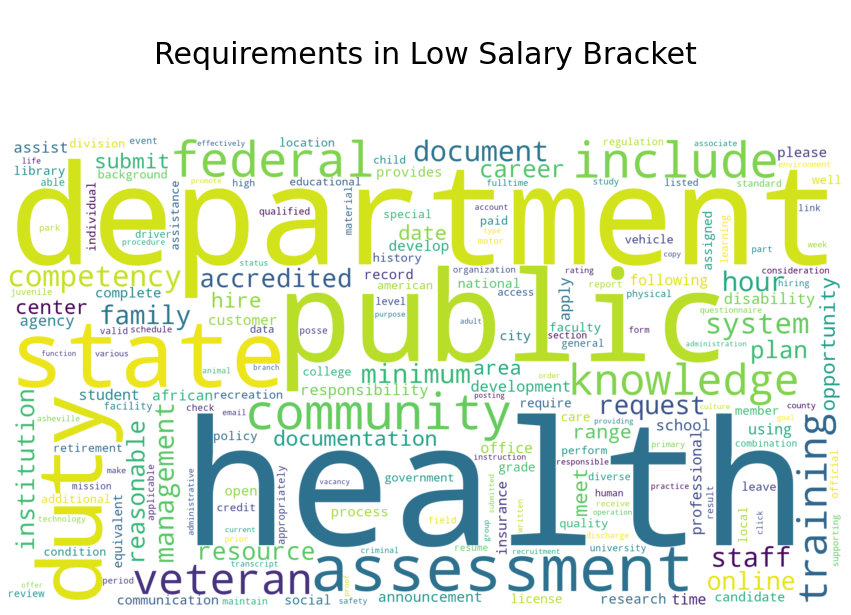

In [9]:
make_wordcloud(' '.join(df[df.salary_bin=='low'].desc.values), '\nRequirements in Low Salary Bracket')

For the Low Salary bin, we can see that the jobs posted are mostly of state departments/public sectors as well as healthcare. 

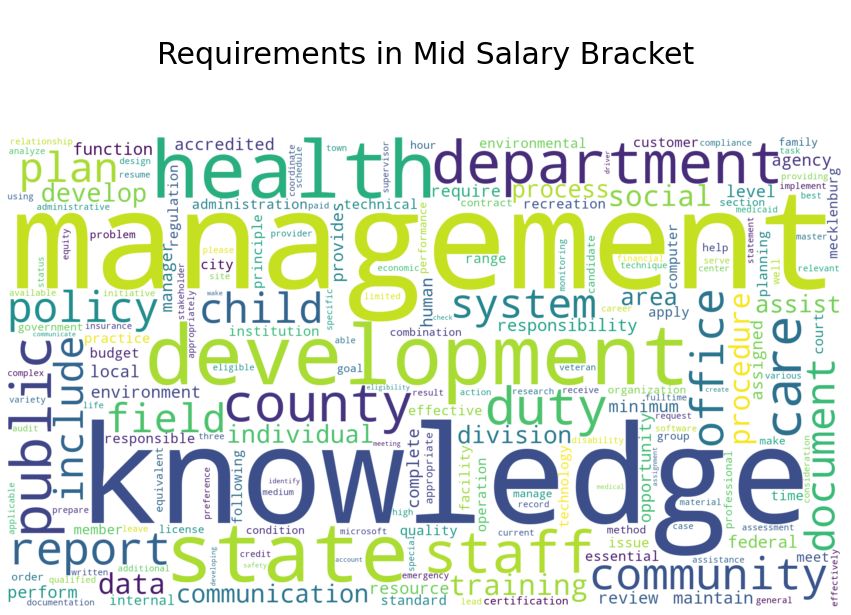

In [10]:
make_wordcloud(' '.join(df[df.salary_bin=='mid'].desc.values), '\nRequirements in Mid Salary Bracket')

For the mid salary level, we have mostly openings in the management section. Also, they have high frequency of words like knowledge and development.

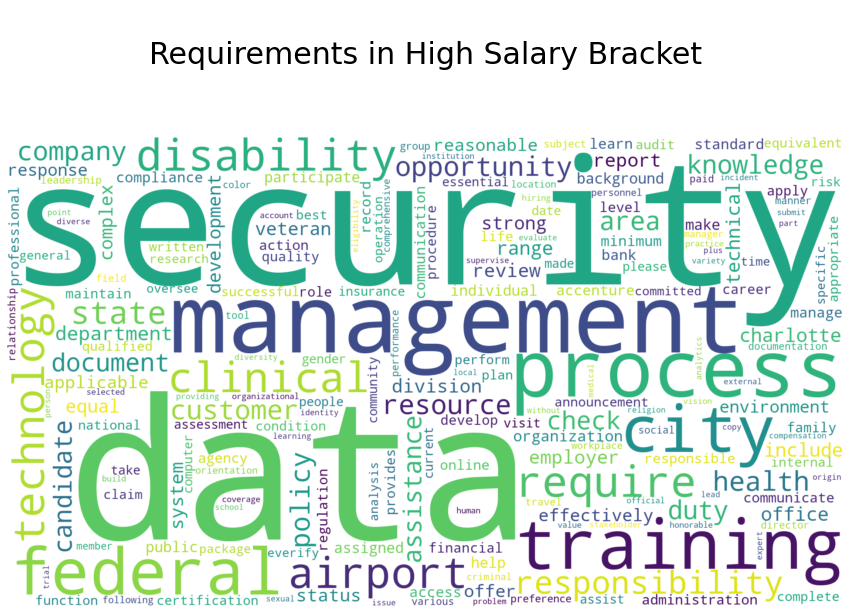

In [11]:
make_wordcloud(' '.join(df[df.salary_bin=='high'].desc.values), '\nRequirements in High Salary Bracket')

Some of the highly paid jobs are in data security and  technology mostly they are with the federal government.

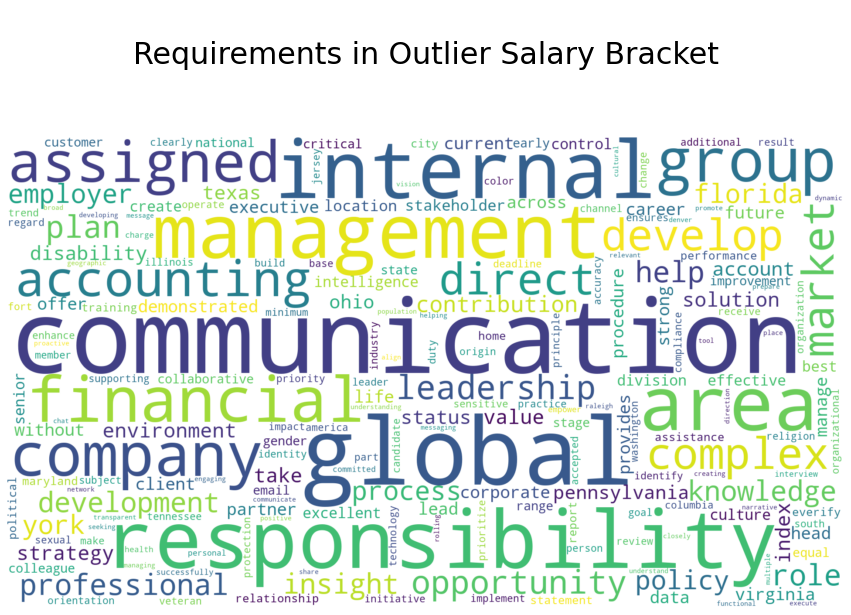

In [12]:
make_wordcloud(' '.join(df[df.salary_bin=='outlier'].desc.values), '\nRequirements in Outlier Salary Bracket')

For the outliers category, we have mostly jobs posted for the management level who needs to have communication skills and can handle global ventures.

# 4. Most Relevant Job Keywords

Next, we find the most relevant keywords using two approaches.
1. We use the CountVectorizer to score each word based on the number of times they occuring
1. We use the TfidfVectorizer to score each word based on the number of times they occuring and normalized by the number of document they appear in

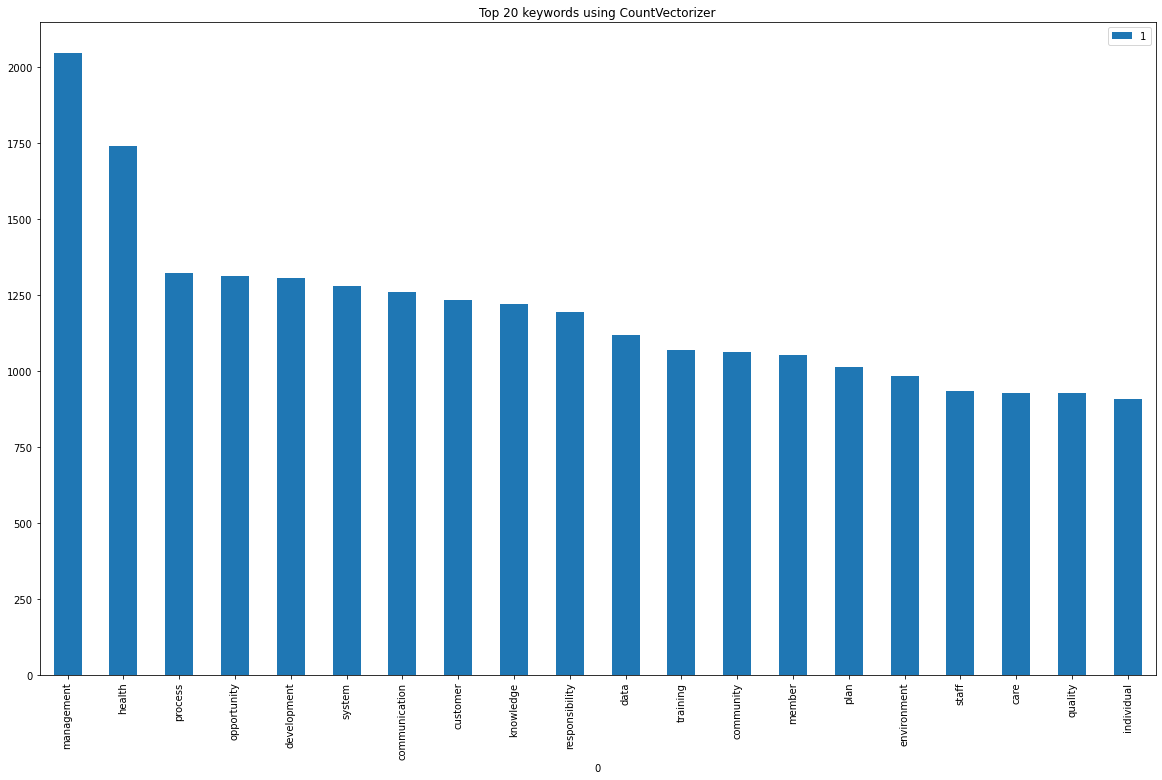

In [13]:
vectorizer = CountVectorizer()
mat = vectorizer.fit_transform(df.desc.values)

pd.DataFrame(zip(vectorizer.get_feature_names(), mat.sum(axis=0).A1)).sort_values(1, ascending=False).head(20).plot.bar(x=0, y=1)
plt.title('Top 20 keywords using CountVectorizer');

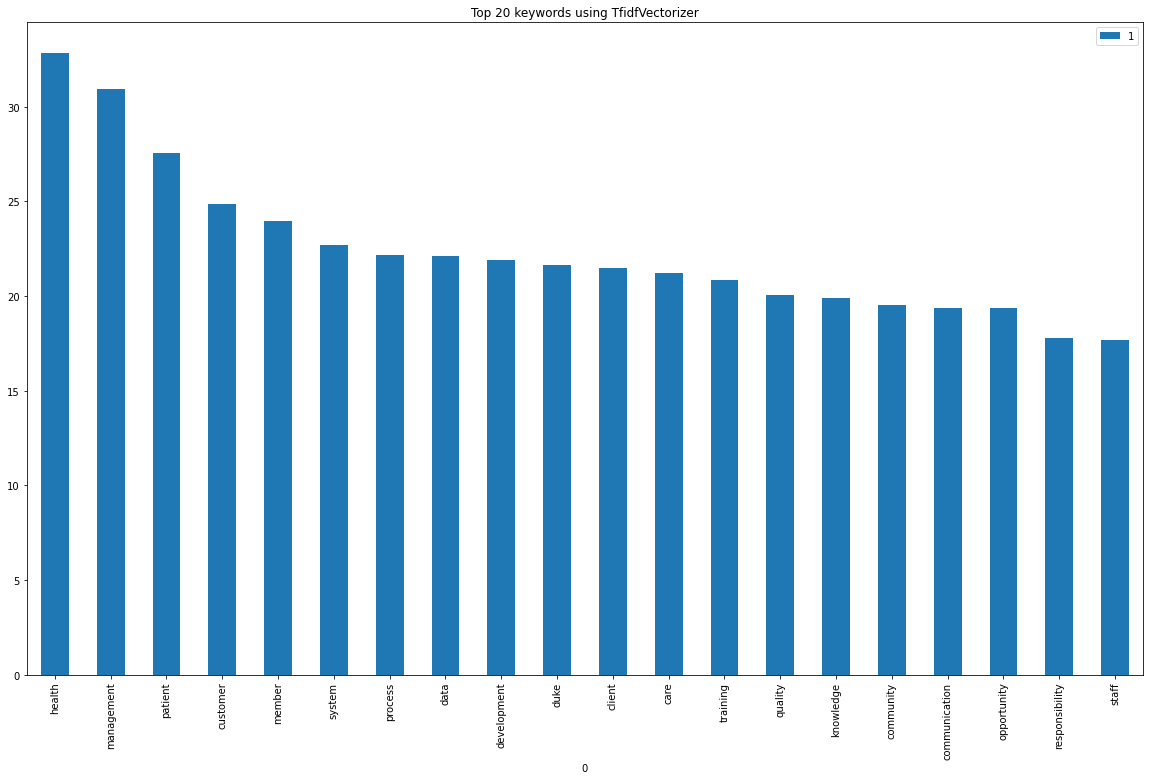

In [14]:
vectorizer = TfidfVectorizer()
mat = vectorizer.fit_transform(df.desc.values)

pd.DataFrame(zip(vectorizer.get_feature_names(), mat.sum(axis=0).A1)).sort_values(1, ascending=False).head(20).plot.bar(x=0, y=1);
plt.title('Top 20 keywords using TfidfVectorizer');

Both the approaches kind of converge and have a similar representation.

# 5.  Topic Modelling on Jobs

The next thing that we perform is grouping the jobs in an unsupervised learning method.

In [15]:
words = [i.split() for i in df.desc]
id2word = corpora.Dictionary(words)
corpus = [id2word.doc2bow(text) for text in words]
lda_model = LdaModel(corpus=corpus,
                        id2word=id2word,
                        num_topics=12, 
                        random_state=100,
                        update_every=1,
                        chunksize=100,
                        passes=20,
                        alpha='auto',
                        per_word_topics=True)

pprint(lda_model.print_topics())


[(0,
  '0.081*"student" + 0.034*"learning" + 0.023*"college" + 0.021*"director" + '
  '0.019*"university" + 0.019*"school" + 0.019*"career" + 0.018*"campus" + '
  '0.014*"office" + 0.013*"course"'),
 (1,
  '0.021*"duty" + 0.015*"individual" + 0.015*"perform" + 0.014*"essential" + '
  '0.010*"responsibility" + 0.008*"manager" + 0.008*"physical" + '
  '0.008*"training" + 0.008*"office" + 0.008*"assist"'),
 (2,
  '0.012*"customer" + 0.011*"opportunity" + 0.010*"client" + 0.009*"company" + '
  '0.008*"status" + 0.008*"solution" + 0.007*"development" + 0.007*"product" + '
  '0.006*"disability" + 0.006*"role"'),
 (3,
  '0.067*"bank" + 0.035*"risk" + 0.024*"loan" + 0.021*"mitigation" + '
  '0.020*"becoming" + 0.017*"wealth" + 0.017*"pattern" + 0.014*"appetite" + '
  '0.010*"exception" + 0.008*"lending"'),
 (4,
  '0.031*"volunteer" + 0.027*"american" + 0.027*"cross" + 0.014*"disaster" + '
  '0.009*"workforce" + 0.009*"regional" + 0.007*"exemption" + '
  '0.007*"emergency" + 0.006*"volunteering

The output shows that we have 12 job clusters and the top 10 words that make up that cluster and from them we can profile the clusters to topics.

In [16]:
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
# vis

![](./ss/1.png)
![](./ss/2.png)
![](./ss/3.png)
![](./ss/4.png)
![](./ss/5.png)
![](./ss/6.png)
![](./ss/7.png)
![](./ss/8.png)
![](./ss/9.png)
![](./ss/10.png)
![](./ss/11.png)
![](./ss/12.png)

* Topic 1: Jobs in System Management
* Topic 2: Jobs in Customer/Client based MNCs
* Topic 3: Health Care Jobs
* Topic 4: Managerial or Supervisor-level Jobs
* Topic 5: Health research jobs mostly in Duke University
* Topic 6: Jobs in State Response Teams
* Topic 7: NA
* Topic 8: Jobs in law enforcement
* Topic 9: Education Sector Jobs
* Topic 10: Volunteer for natural calamities and emergencies
* Topic 11: Risk Analysis Bank
* Topic 12: NA


So, since we did a multi dimensional analysis to find the topics for the cluster of jobs, we can confidently say that we can merge Topic 1 and 2, Topic 6 and 10. We can omit the jobs clustered in the topic 7 and 12 because they are not that interpretable.

# 6. WordCloud on College Courses

Next we will just validate the data cleaning by plotting the WordClouds for each of the colleges to see if there are any unnecessary words that occurs in high frequency.

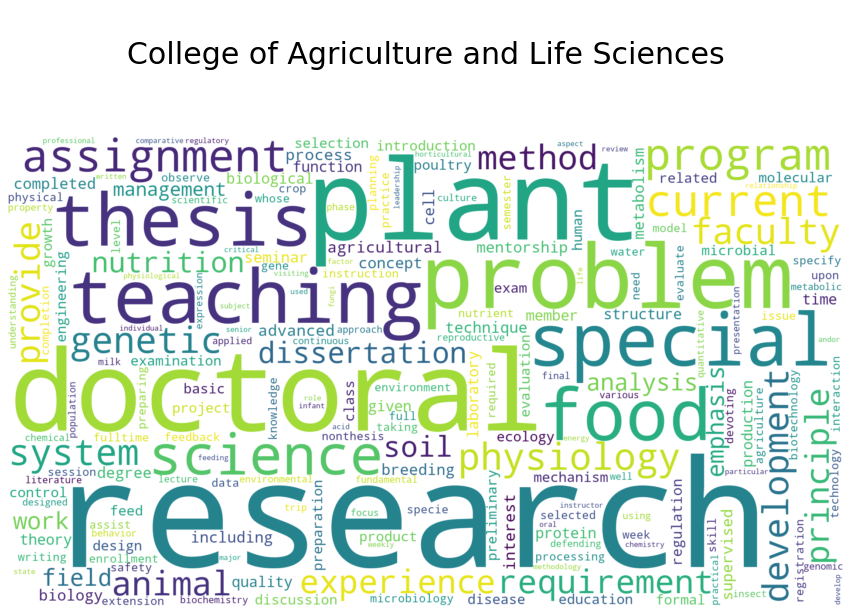

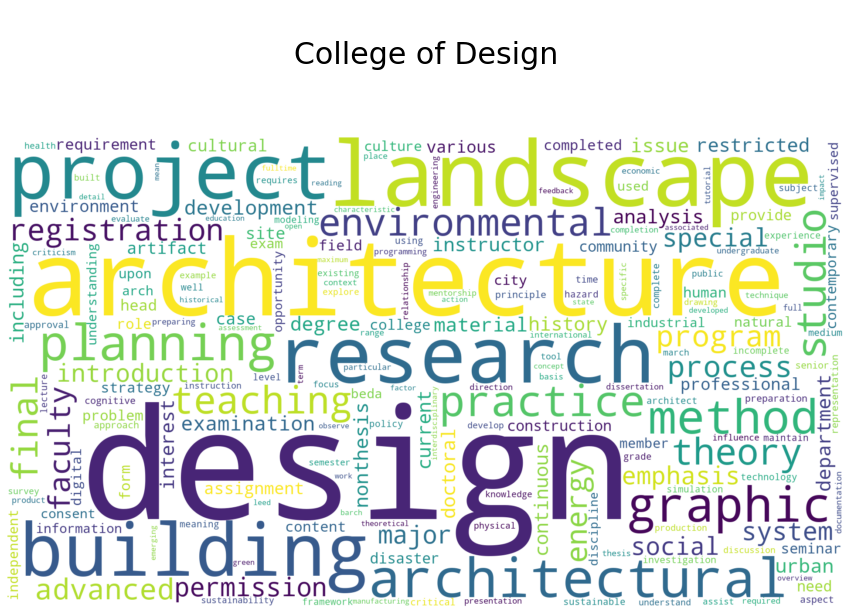

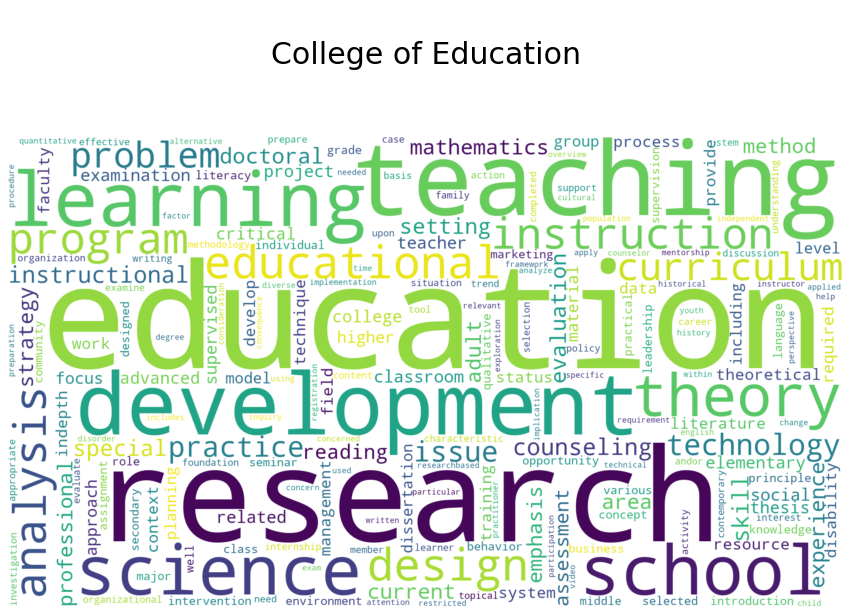

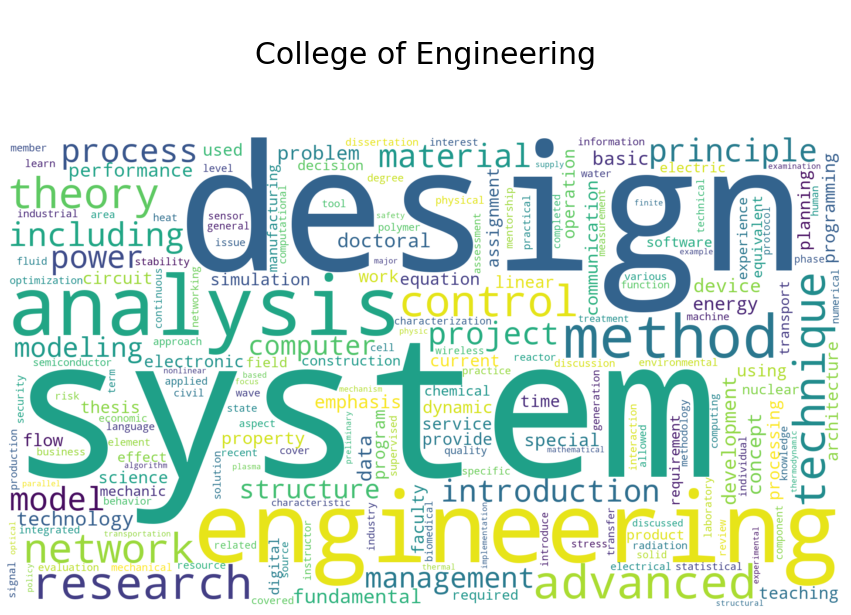

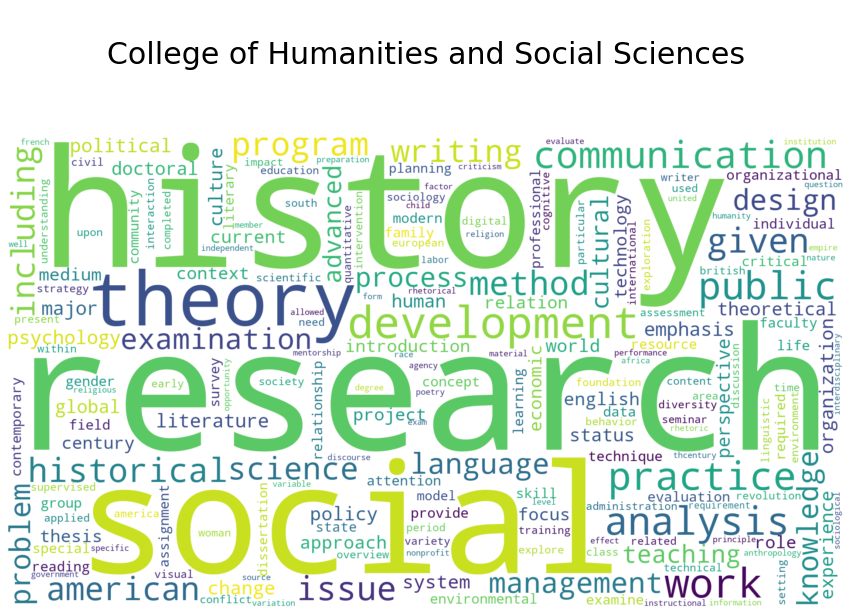

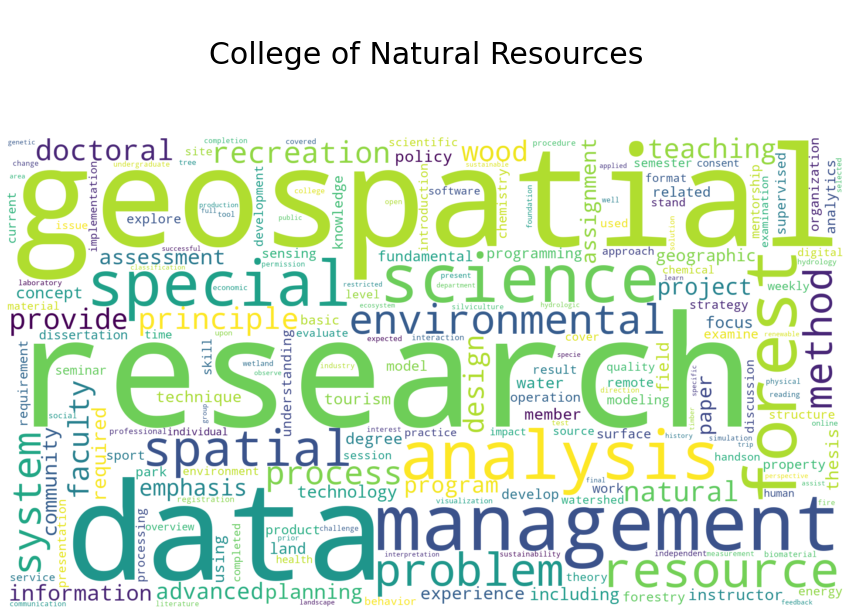

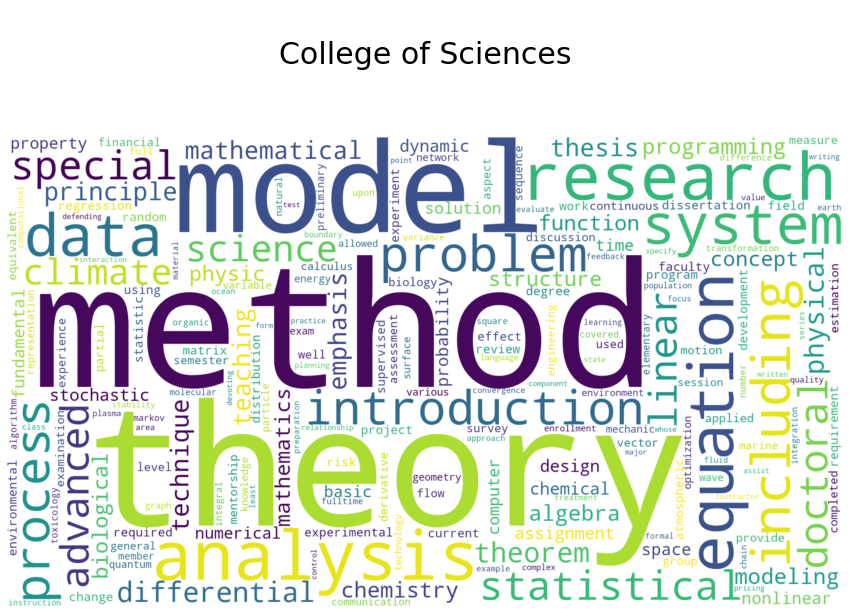

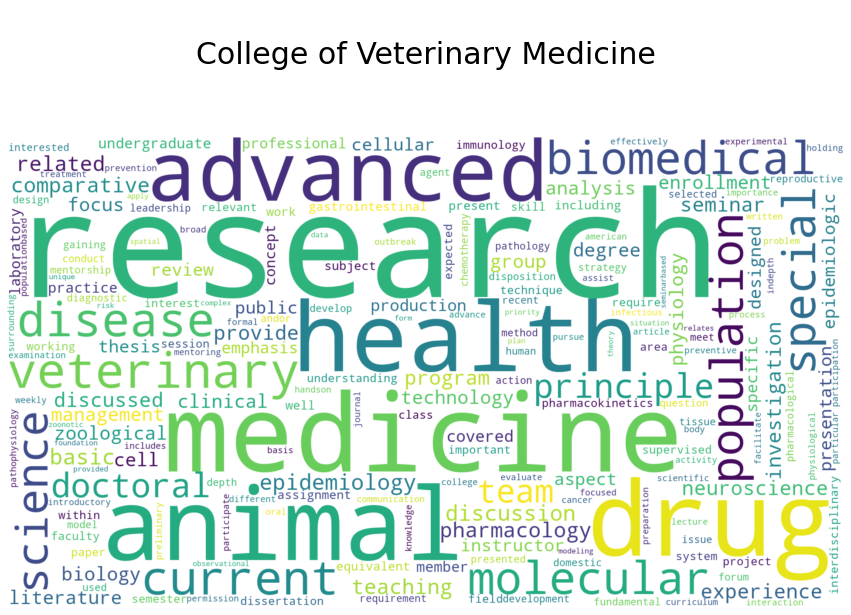

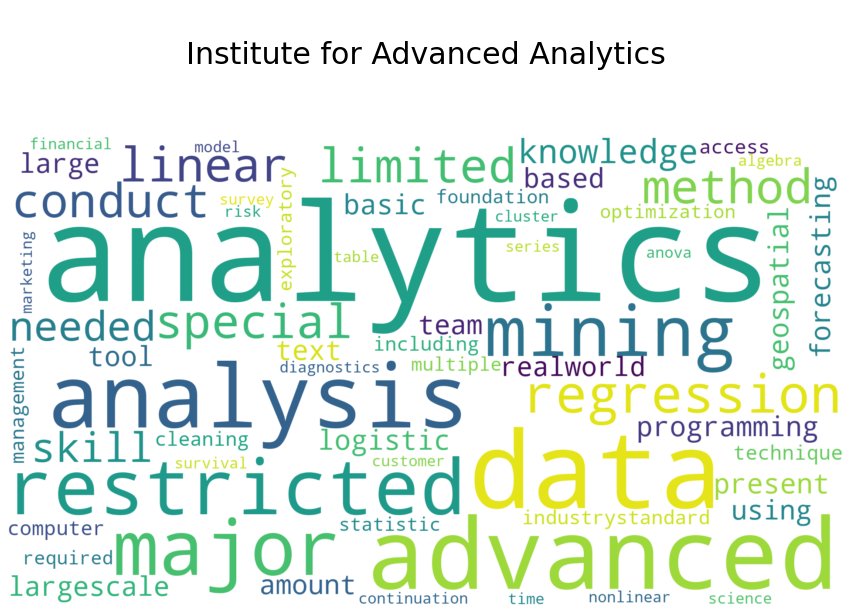

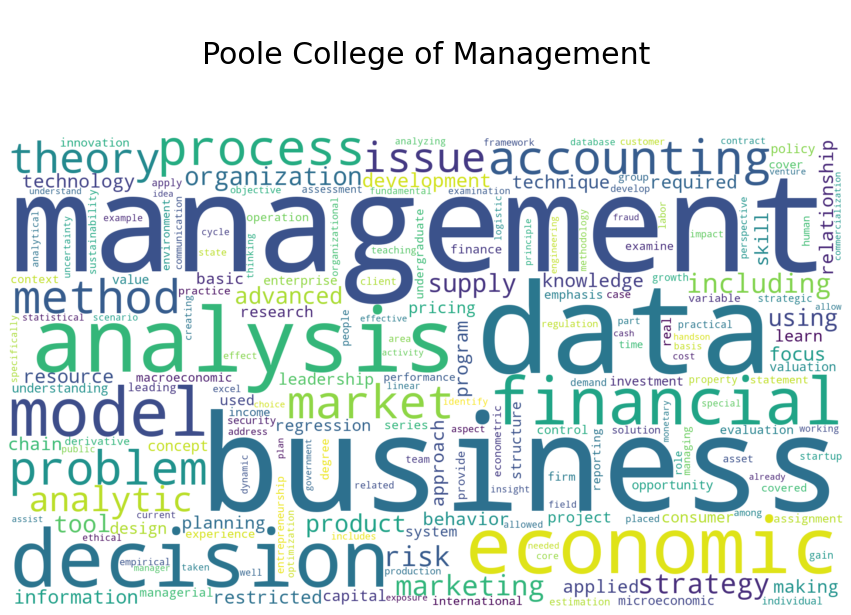

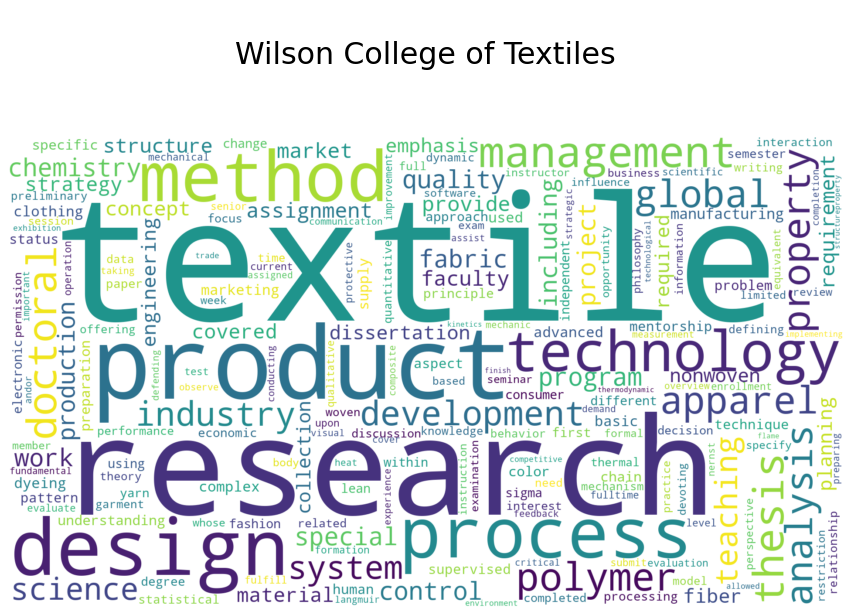

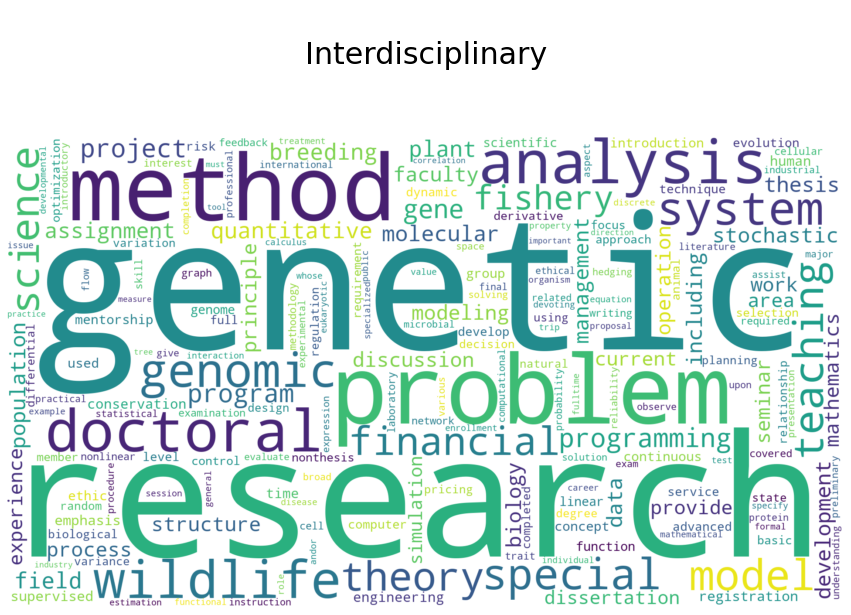

In [17]:
for i in df_ns.college.unique()[:-1]:
    make_wordcloud(' '.join(df_ns[df_ns.college == i].course_content.values), f'\n{i}')

All the WordClouds looks good and portray the keywords of each course.

# 7. Mapping the Top Job Keywords with relevant Colleges

Now, from the top keywords that we have for the job pool, we can identify the courses which can easily guarantee a job.


In [18]:
from collections import Counter
import math

WORD = re.compile(r"\w+")

def get_cosine(vec1, vec2):
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x] ** 2 for x in list(vec1.keys())])
    sum2 = sum([vec2[x] ** 2 for x in list(vec2.keys())])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator


def text_to_vector(text):
    words = WORD.findall(text)
    return Counter(words)

In [19]:
n = 500

vectorizer = TfidfVectorizer()
mat = vectorizer.fit_transform(df.desc.values)

job_kws = ' '.join(pd.DataFrame(zip(vectorizer.get_feature_names(), mat.sum(axis=0).A1)).sort_values(1, ascending=False).head(n)[0].values)

college_kws = {}
for i in df_ns.college.unique()[:-1]:
    
    vectorizer = TfidfVectorizer()
    mat = vectorizer.fit_transform(df_ns[df_ns.college == i].course_content.values)
    
    college_kws[i] = ' '.join(pd.DataFrame(zip(vectorizer.get_feature_names(), mat.sum(axis=0).A1)).sort_values(1, ascending=False).head(n)[0].values)

cosine_df = pd.DataFrame(columns=['college', 'score'])
for i in college_kws.items():
    cosine_sim = get_cosine(text_to_vector(job_kws), text_to_vector(i[1]))
    cosine_df.loc[len(cosine_df)] = [i[0], round(cosine_sim, 2)]
    
cosine_df.sort_values('score', ascending=False).reset_index(drop=True).drop('score', axis=1).head(3)

college
0   Poole College of Management
1          College of Education
2  College of Natural Resources

We see here that based on the availability of the jobs, the management, education and natural resources are the top 3 colleges whose course description matches closely with majority of the jobs posted on Indeed.

# 8. Mapping the Top Job Keywords on Salary with the Subjects

Next, we can identify the key colleges that offers courses which are highly similar to the requirements based on the salary offered.


## 8.1 For Low Salaries

In [20]:
n = 1000

vectorizer = TfidfVectorizer()
mat = vectorizer.fit_transform(df[df.salary_bin=='low'].desc.values)

job_kws = ' '.join(pd.DataFrame(zip(vectorizer.get_feature_names(), mat.sum(axis=0).A1)).sort_values(1, ascending=False).head(n)[0].values)

college_kws = {}
for i in df_ns.college.unique()[:-1]:
    
    vectorizer = TfidfVectorizer()
    mat = vectorizer.fit_transform(df_ns[df_ns.college == i].course_content.values)
    
    college_kws[i] = ' '.join(pd.DataFrame(zip(vectorizer.get_feature_names(), mat.sum(axis=0).A1)).sort_values(1, ascending=False).head(n)[0].values)

cosine_df = pd.DataFrame(columns=['college', 'score'])
for i in college_kws.items():
    cosine_sim = get_cosine(text_to_vector(job_kws), text_to_vector(i[1]))
    cosine_df.loc[len(cosine_df)] = [i[0], round(cosine_sim, 2)]
    
cosine_df.sort_values('score', ascending=False).reset_index(drop=True).drop('score', axis=1).head(3)

college
0                       College of Education
1  College of Humanities and Social Sciences
2                Poole College of Management

We can see that the College of Education, Social Sciences and Management provide the lowest salaries.

## 8.2 For Mid Salaries

In [21]:
n = 100

vectorizer = TfidfVectorizer()
mat = vectorizer.fit_transform(df[df.salary_bin=='mid'].desc.values)

job_kws = ' '.join(pd.DataFrame(zip(vectorizer.get_feature_names(), mat.sum(axis=0).A1)).sort_values(1, ascending=False).head(n)[0].values)

college_kws = {}
for i in df_ns.college.unique()[:-1]:
    
    vectorizer = TfidfVectorizer()
    mat = vectorizer.fit_transform(df_ns[df_ns.college == i].course_content.values)
    
    college_kws[i] = ' '.join(pd.DataFrame(zip(vectorizer.get_feature_names(), mat.sum(axis=0).A1)).sort_values(1, ascending=False).head(n)[0].values)

cosine_df = pd.DataFrame(columns=['college', 'score'])
for i in college_kws.items():
    cosine_sim = get_cosine(text_to_vector(job_kws), text_to_vector(i[1]))
    cosine_df.loc[len(cosine_df)] = [i[0], round(cosine_sim, 2)]
    
cosine_df.sort_values('score', ascending=False).reset_index(drop=True).drop('score', axis=1).head(3)

college
0               College of Natural Resources
1  College of Humanities and Social Sciences
2                          College of Design

We can see that the College of Natural Resources, Social Sciences and Design provide decent salaries.

## 8.3 For High Salaries

In [22]:
n = 90

vectorizer = TfidfVectorizer()
mat = vectorizer.fit_transform(df[df.salary_bin=='high'].desc.values)

job_kws = ' '.join(pd.DataFrame(zip(vectorizer.get_feature_names(), mat.sum(axis=0).A1)).sort_values(1, ascending=False).head(n)[0].values)

college_kws = {}
for i in df_ns.college.unique()[:-1]:
    
    vectorizer = TfidfVectorizer()
    mat = vectorizer.fit_transform(df_ns[df_ns.college == i].course_content.values)
    
    college_kws[i] = ' '.join(pd.DataFrame(zip(vectorizer.get_feature_names(), mat.sum(axis=0).A1)).sort_values(1, ascending=False).head(n)[0].values)

cosine_df = pd.DataFrame(columns=['college', 'score'])
for i in college_kws.items():
    cosine_sim = get_cosine(text_to_vector(job_kws), text_to_vector(i[1]))
    cosine_df.loc[len(cosine_df)] = [i[0], round(cosine_sim, 2)]
    
cosine_df.sort_values('score', ascending=False).reset_index(drop=True).drop('score', axis=1).head(4)

college
0                Poole College of Management
1                       College of Education
2  College of Humanities and Social Sciences
3           Institute for Advanced Analytics

The Management School, as well as the Education, Social Sciences and Advanced Analytics offers really high salary.

## 8.4 For Outlier Salaries

In [23]:
n = 300

vectorizer = TfidfVectorizer()
mat = vectorizer.fit_transform(df[df.salary_bin=='outlier'].desc.values)

job_kws = ' '.join(pd.DataFrame(zip(vectorizer.get_feature_names(), mat.sum(axis=0).A1)).sort_values(1, ascending=False).head(n)[0].values)

college_kws = {}
for i in df_ns.college.unique()[:-1]:
    
    vectorizer = TfidfVectorizer()
    mat = vectorizer.fit_transform(df_ns[df_ns.college == i].course_content.values)
    
    college_kws[i] = ' '.join(pd.DataFrame(zip(vectorizer.get_feature_names(), mat.sum(axis=0).A1)).sort_values(1, ascending=False).head(n)[0].values)

cosine_df = pd.DataFrame(columns=['college', 'score'])
for i in college_kws.items():
    cosine_sim = get_cosine(text_to_vector(job_kws), text_to_vector(i[1]))
    cosine_df.loc[len(cosine_df)] = [i[0], round(cosine_sim, 2)]
    
cosine_df.sort_values('score', ascending=False).reset_index(drop=True).drop('score', axis=1).head(3)

college
0                Poole College of Management
1                       College of Education
2  College of Humanities and Social Sciences

We again have a mixed bag here with the Management, Education and Social Science being offered an exceptional high salary.

## 8.5 Map Colleges with the modelled Topics

So, now we are trying to predict/transform each job listing's description with the topics generated by our LDA model. The process is:
1. We will take the top 2 keywords for each topic (output of the LDA model) because they best describe the topic. 1. Next, for each job description, and each topic we will try to find if any of the top 2 keywords exist. If yes, we classify the document as that topic. 
1. We can have multiple classifications of topics for each document. 
1. Finally we One-Hot_Encode the classified topic numbers and fit that into a new dataframe
.

In [24]:
topic_words = dict(zip(range(12), [[j.split('"')[1] for j in i[1].split('*')[1:]][:2] for i in lda_model.print_topics()]))
predict = []
for desc in df.desc:
    temp_predict = []
    for topic in topic_words.keys():
        if len(set(topic_words[topic])) > len(set(topic_words[topic]) - set(desc.split())):
               temp_predict.extend([topic])
        else:
            temp_predict.extend([13])
    predict.extend([[1 if i in temp_predict else 0 for i in range(12)]])    

df_map = pd.DataFrame([[df.desc.values[n]]+ [df.salary_cleaned.values[n]] + i for n,i in enumerate(predict)], 
             columns=[
                 'desc',
                 'salary',
                 'System_Management',
                 'Customer_Client',
                 'Health_Care',
                 'Managerial_Supervisor',
                 'Health_Research',
                 'State_Response_Teams',
                 'NA1',
                 'Law_Enforcement',
                 'Education_Sector',
                 'Volunteer',
                 'Risk_Analysis',
                 'NA2',
             ])
df_map.drop(['NA1', 'NA2'], inplace=True, axis=1)
df_map.head()

desc    salary  \
0  note applying opportunity share location follo...   78000.0   
1  primary purpose organizational unitthe primary...       0.0   
2  note applying opportunity share location follo...  102000.0   
3  please google chrome mozilla firefox accessing...       0.0   
4  posting department african afrlamer diaspora c...   34346.0   

   System_Management  Customer_Client  Health_Care  Managerial_Supervisor  \
0                  0                0            1                      0   
1                  1                0            0                      0   
2                  0                0            1                      0   
3                  0                1            1                      0   
4                  1                0            1                      0   

   Health_Research  State_Response_Teams  Law_Enforcement  Education_Sector  \
0                0                     0                0                 0   
1                1                     0                0                 0   
2                0                     0                1                 0   
3                1                     0                1                 1   
4                1                     0                1                 0   

   Volunteer  Risk_Analysis  
0          0              0  
1          0              0  
2          0              0  
3          1              0  
4          0              0

# 9. Distibution of Salary in each topic



--- Salary distribution for System_Management ---


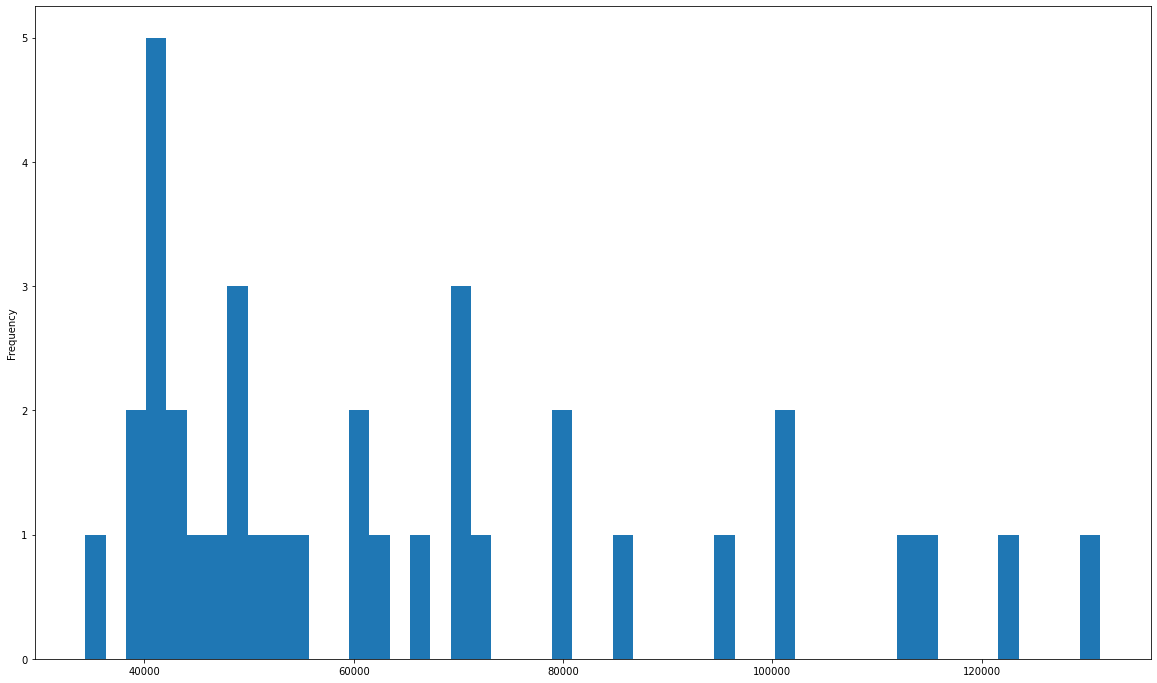



--- Salary distribution for Customer_Client ---


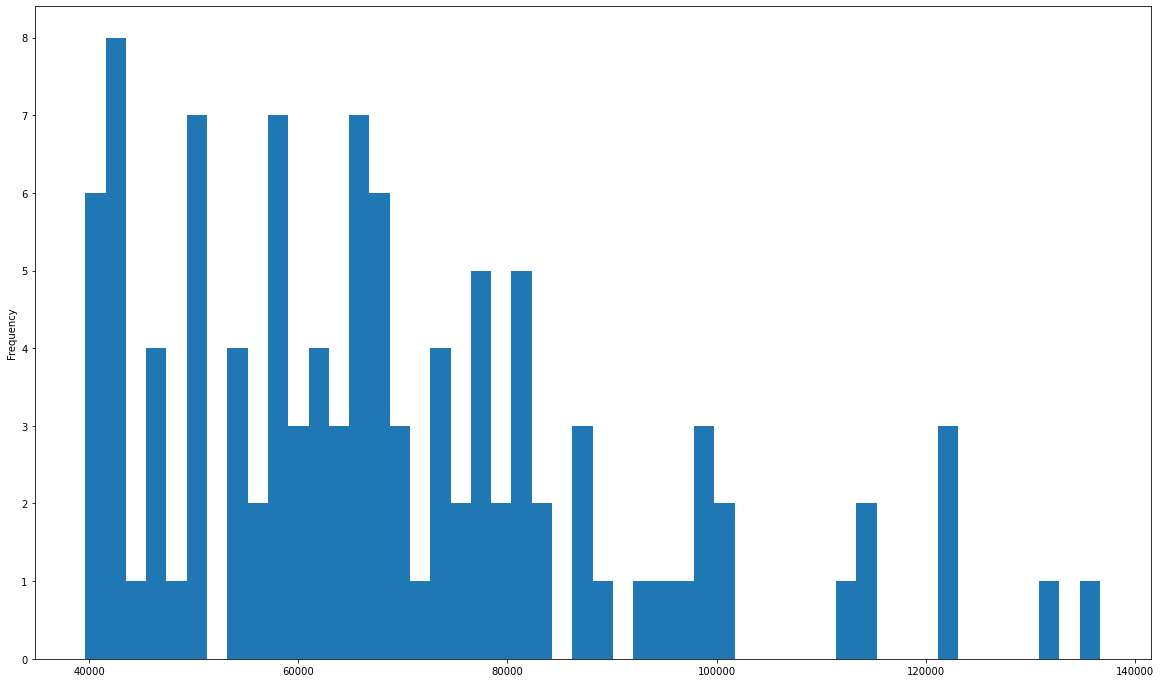



--- Salary distribution for Health_Care ---


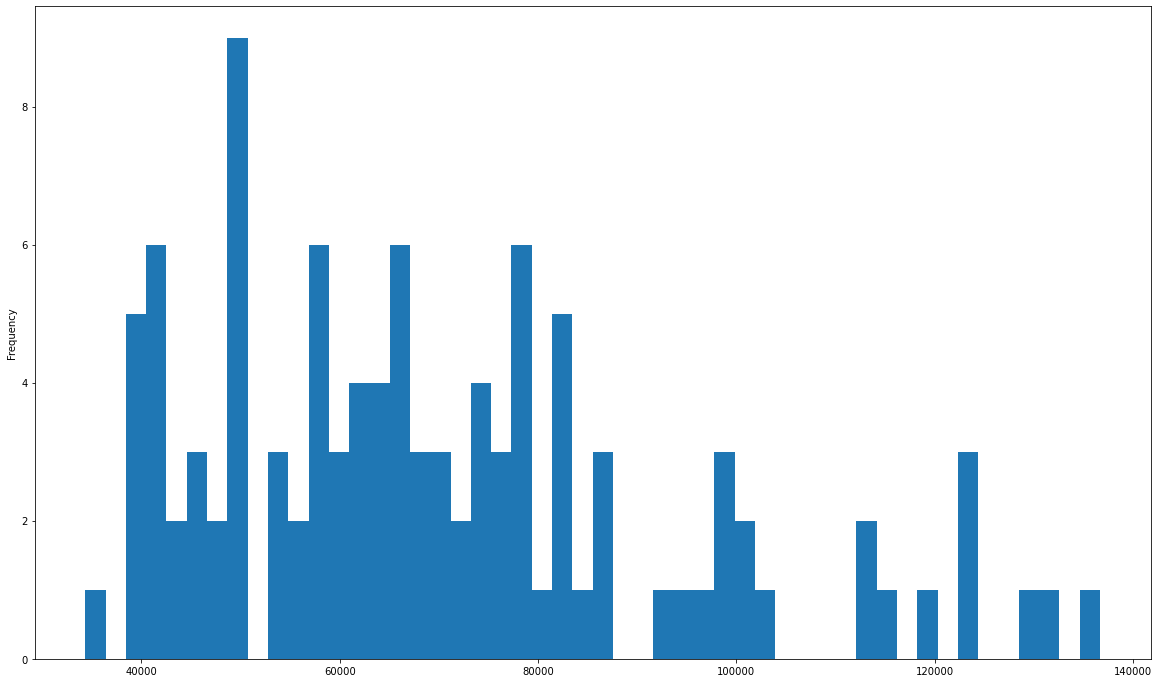



--- Salary distribution for Managerial_Supervisor ---


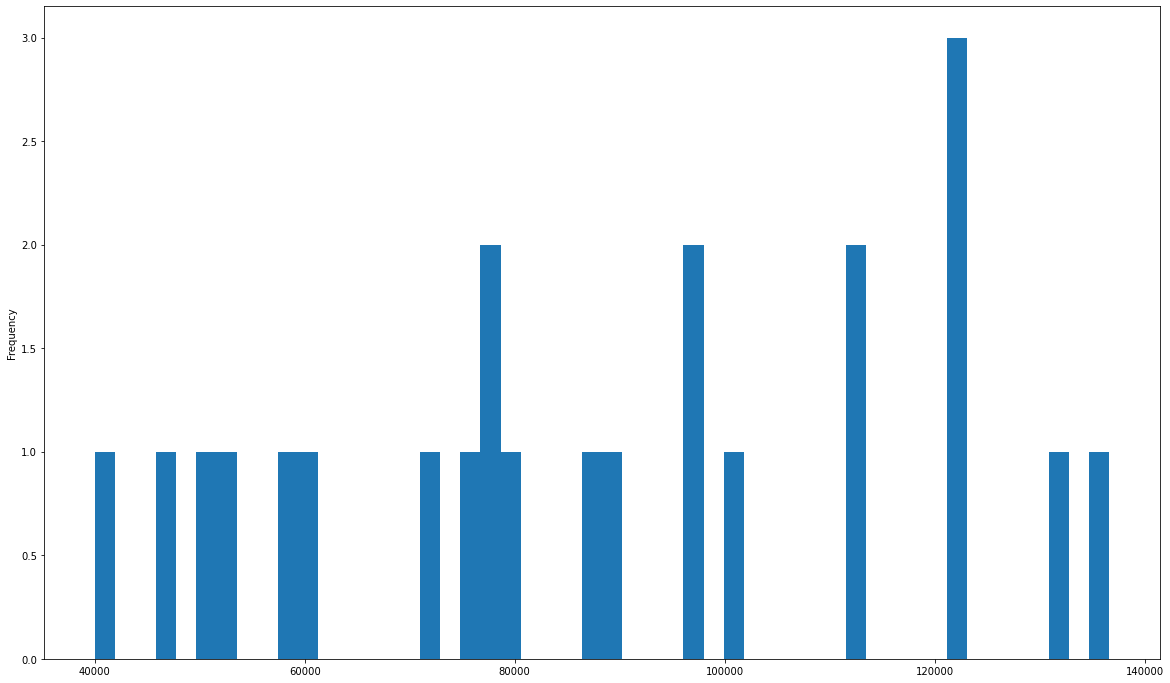



--- Salary distribution for Health_Research ---


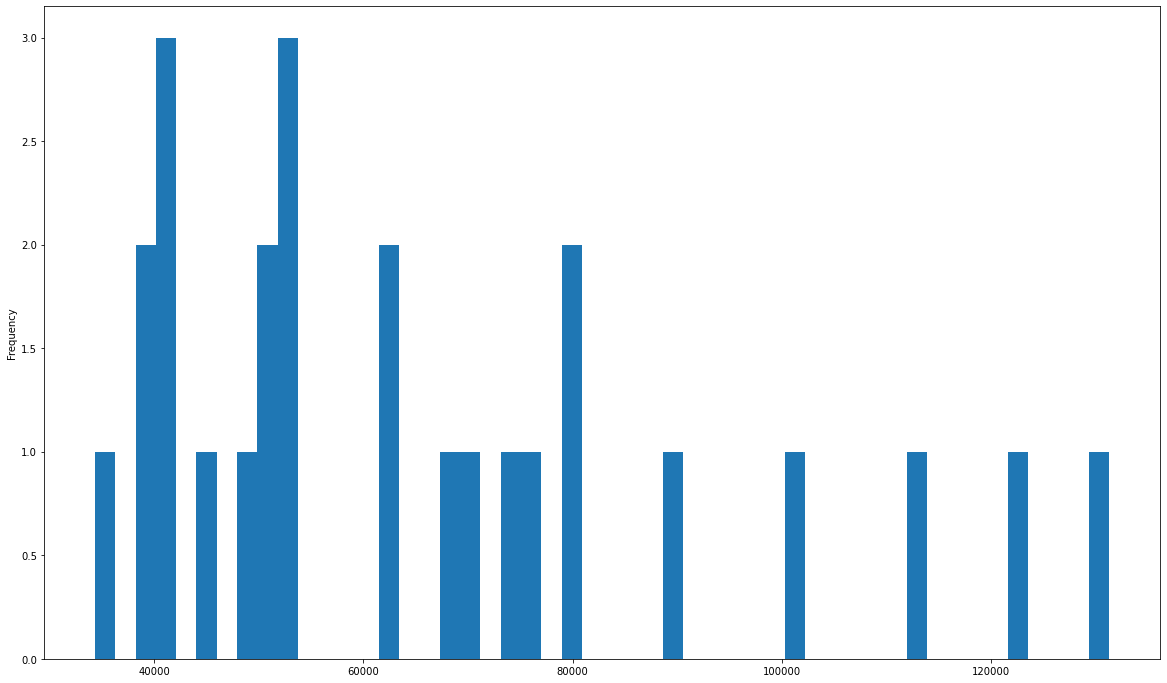



--- Salary distribution for State_Response_Teams ---


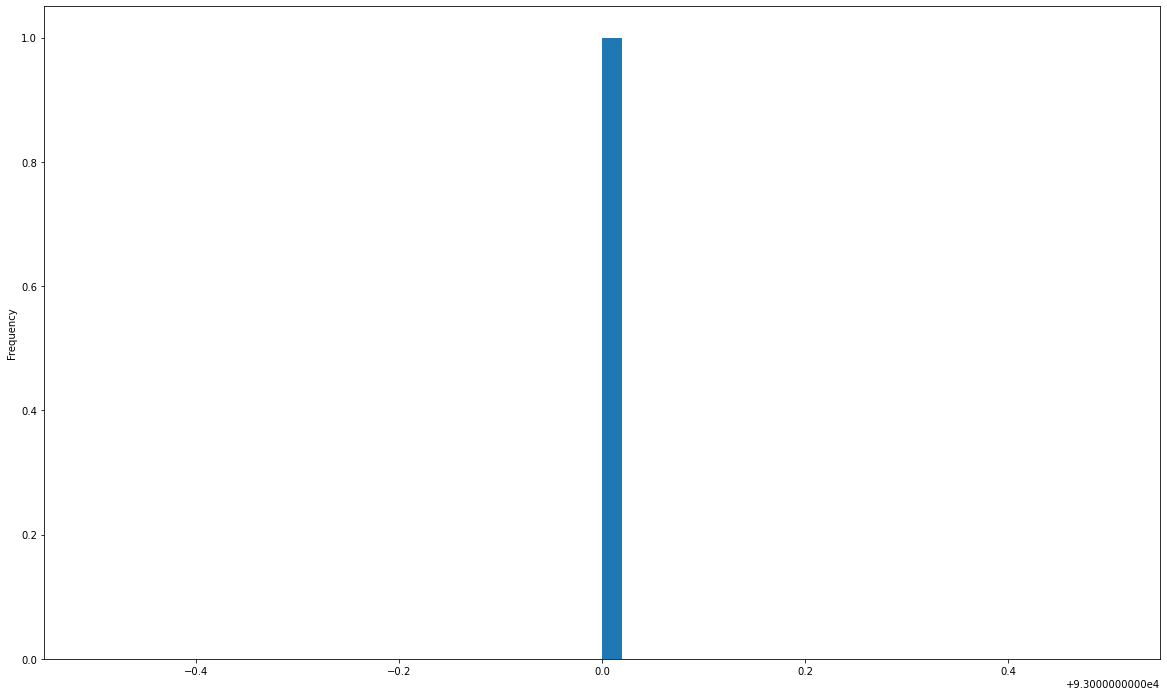



--- Salary distribution for Law_Enforcement ---


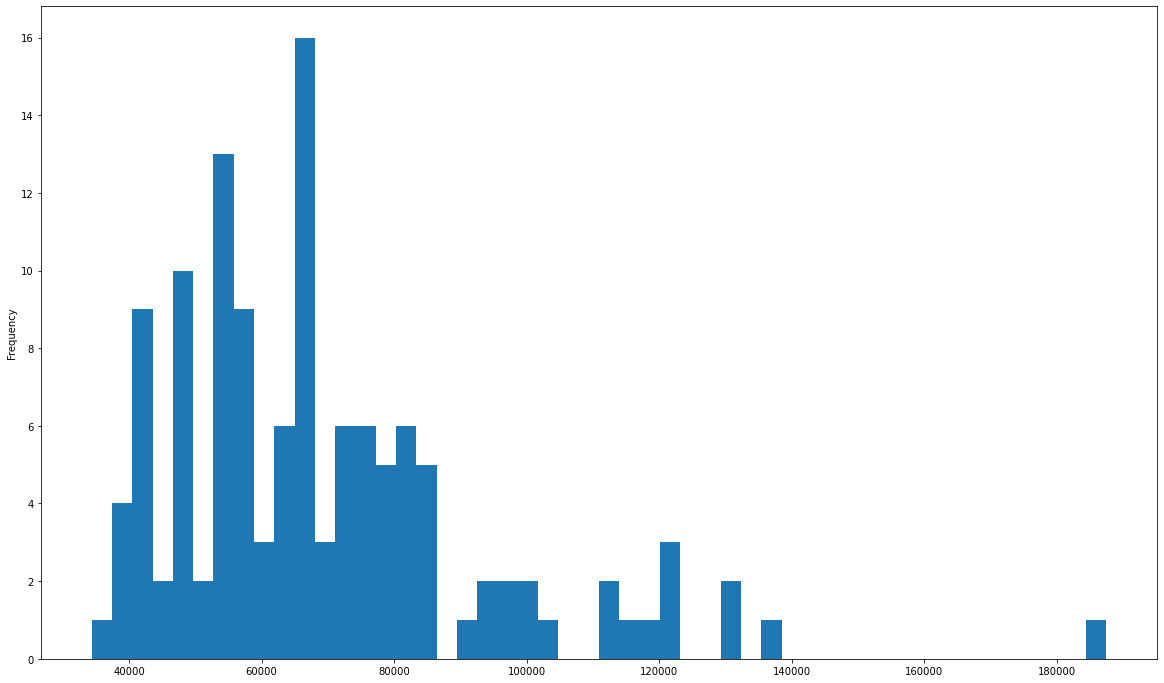



--- Salary distribution for Education_Sector ---


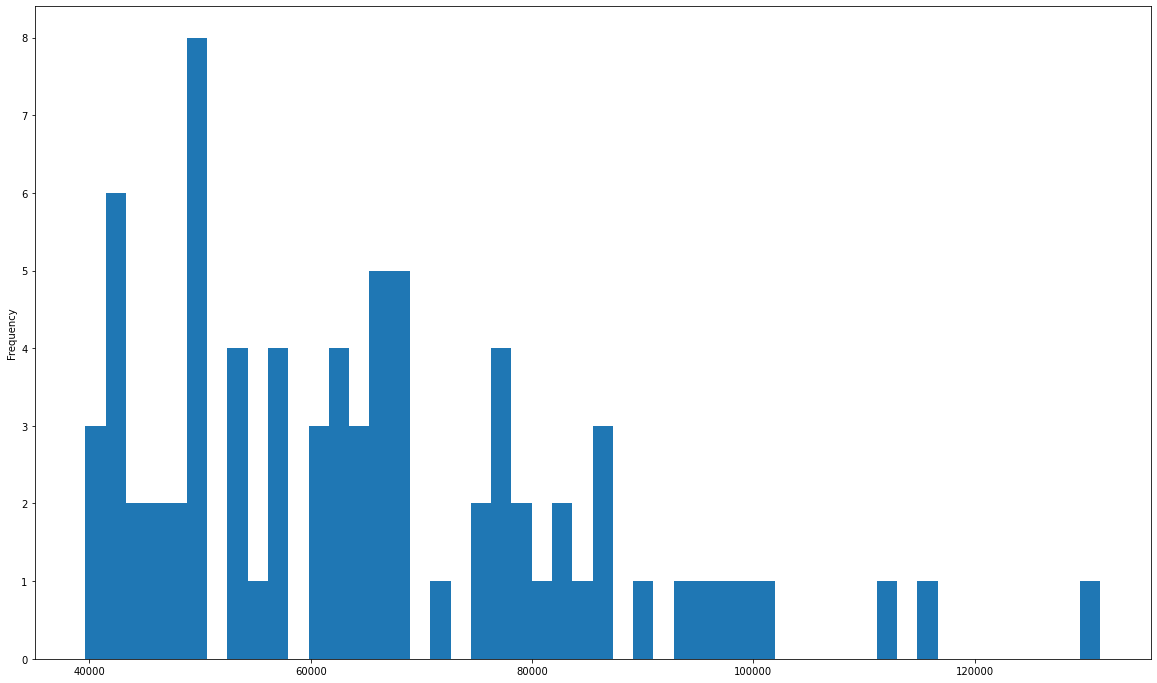



--- Salary distribution for Volunteer ---


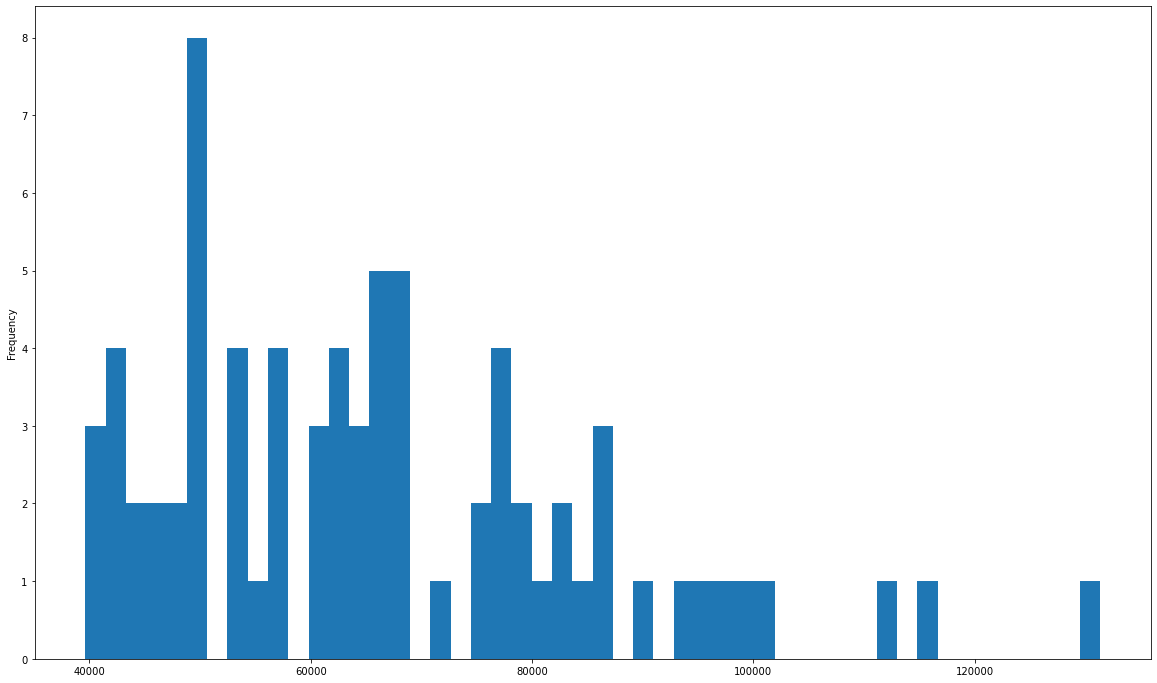



--- Salary distribution for Risk_Analysis ---


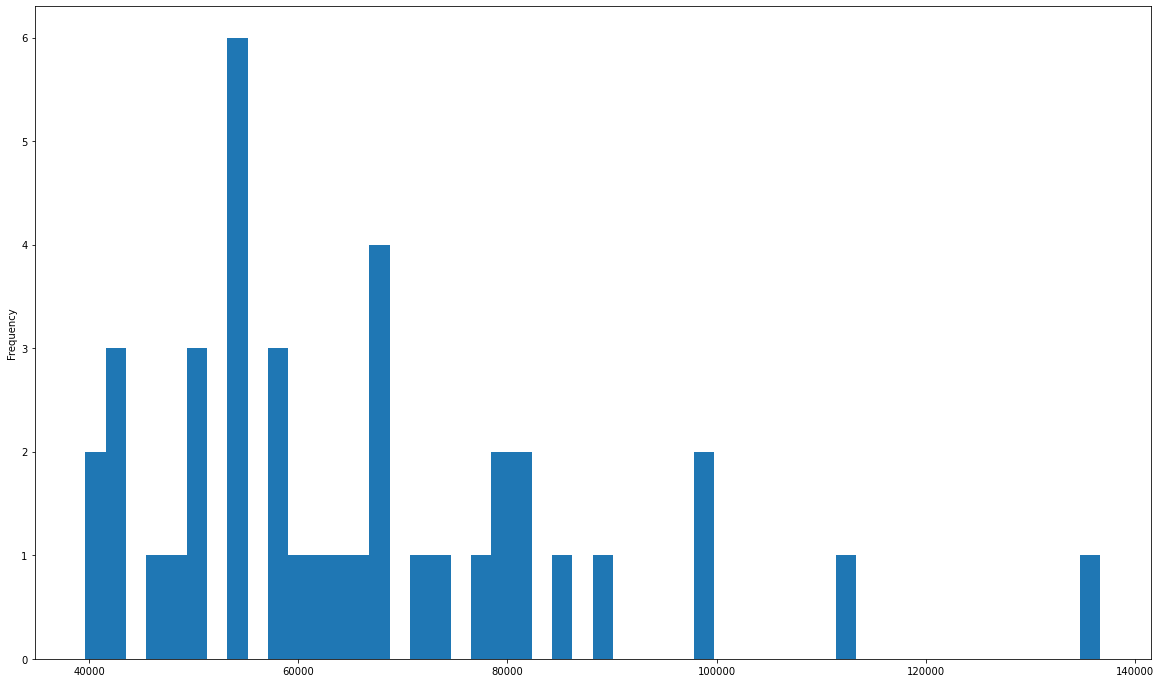

In [25]:
for j,topic in enumerate(['System_Management', 'Customer_Client', 'Health_Care', 'Managerial_Supervisor', 'Health_Research', 'State_Response_Teams', 'Law_Enforcement', 'Education_Sector', 'Volunteer', 'Risk_Analysis']):
    print(f'\n\n--- Salary distribution for {topic} ---')
    df_map[(df_map[topic]==1)&(df_map.salary>0)].salary.plot.hist(bins=50)
    plt.show();

# 10. Recommend the best suitable college for each topic

So, once we have associated the relevant topics for each job description, we perform a cosine-similarity test on each topic.
1. We get the top n words using the tfidf vectorizer for all the documents classified for the topic
1. We get the top n words using the tfidf vectorizer for each of the colleges curriculum
1. We compare the selected topic with each of the college courses and output the top k columns

Here, there are two hyper-parameters - the number of topic to be selected and the k-best colleges which we fine-tuned manually.

In [26]:
n = [20, 20, 20, 20, 1, 7, 8, 500, 5, 15]
h = [2, 1, 1, 2, 3, 1, 2, 1, 2, 2]


vectorizer = TfidfVectorizer()

for j,topic in enumerate(['System_Management', 'Customer_Client', 'Health_Care', 'Managerial_Supervisor', 'Health_Research', 'State_Response_Teams', 'Law_Enforcement', 'Education_Sector', 'Volunteer', 'Risk_Analysis']):
    print(f'\n\n--- Colleges for {topic} ---')
    mat = vectorizer.fit_transform(df_map[df_map[topic]==1].desc.values)

    job_kws = ' '.join(pd.DataFrame(zip(vectorizer.get_feature_names(), mat.sum(axis=0).A1)).sort_values(1, ascending=False).head(n[j])[0].values)

    college_kws = {}
    for i in df_ns.college.unique()[:-1]:

        vectorizer = TfidfVectorizer()
        mat = vectorizer.fit_transform(df_ns[df_ns.college == i].course_content.values)

        college_kws[i] = ' '.join(pd.DataFrame(zip(vectorizer.get_feature_names(), mat.sum(axis=0).A1)).sort_values(1, ascending=False).head(n[j])[0].values)

    cosine_df = pd.DataFrame(columns=['college', 'score'])
    for i in college_kws.items():
        cosine_sim = get_cosine(text_to_vector(job_kws), text_to_vector(i[1]))
        cosine_df.loc[len(cosine_df)] = [i[0], round(cosine_sim, 2)]

    print(cosine_df.sort_values('score', ascending=False).drop('score', axis=1).reset_index(drop=True).head(h[j]))



--- Colleges for System_Management ---
                  college
0    College of Education
1  College of Engineering


--- Colleges for Customer_Client ---
                  college
0  College of Engineering


--- Colleges for Health_Care ---
                  college
0  College of Engineering


--- Colleges for Managerial_Supervisor ---
                       college
0  Poole College of Management
1       College of Engineering


--- Colleges for Health_Research ---
                                    college
0  College of Agriculture and Life Sciences
1                         College of Design
2                      College of Education


--- Colleges for State_Response_Teams ---
                        college
0  College of Natural Resources


--- Colleges for Law_Enforcement ---
                        college
0        College of Engineering
1  College of Natural Resources


--- Colleges for Education_Sector ---
                college
0  College of Education


--- Colleges for 

# 11. Conclusion

1. We have found the top keywords for all the jobs.
1. We have found the top keywords for the jobs grouped on the salary bins.
1. We have seen how the word frequencies are in college courses.
1. We grouped the jobs based on salary and topics.
1. We found the relevant courses for the jobs grouped on salary.
1. We found the relevant courses for the jobs grouped on courses.
1. There is as such no co-relation in the distribution of salary and the job topics.
1. We are able to recommend the best colleges based on salary requirements.
1. We also recommended the best colleges for the job topics we have identified.

# 12. Bibliography

Annotated Bibliography:
Lang et al. - Automated Extraction of Learning Goals and Objecti.pdf. (n.d.). Retrieved May 31, 2020, link to article

This project also uses LDA topic modeling and NNs to analyze courses, but it uses a 
corpus of syllabi rather than course summaries. 

Agrawal et al. - 2016—Toward Data-Driven Design of Educational Courses .pdf. (n.d.). Retrieved May 31, 2020, from https://www.cs.ucr.edu/~epapalex/papers/JEDM16.pdf

This article may be useful as they use a particular area (physics) to develop a general 
approach to creating study plans through educational data mining, but they are not using 
topic modeling--they’re using wikipedia as the conceptual map to graph the 
relationships between concepts. 

Aguilar, J.; Salazar, C.; Velasco, H.; Monsalve-Pulido, J.; Montoya, E. Comparison and Evaluation of Different Methods for the Feature Extraction from Educational Contents. Computation 2020, 8, 30.
https://www.mdpi.com/2079-3197/8/2/30

This article compares LDA to other methods, such as Doc2Vec, LSA, and MB25. Will be useful in explaining why we chose LDA. 




Al-Raisi—Optimization for Content Generation and Evaluation. (n.d.). Retrieved May 31, 2020, link to article

The work demonstrated in this article (summary of a thesis) attempts to model course 
content at the level of concept, module, and curriculum levels. And then raises some key 
questions after exploring the issues related to the work. Here’s one, in particular, that is 
potentially useful for our project: “What are the recommended evaluation methods and 
metrics to be used to evaluate output generated from the coherent content generator and 
curriculum planner developed? Are there any (benchmark) datasets useful for these tasks?”

ALSaad, F., Boughoula, A., Geigle, C., Sundaram, H., & Zhai, C. (2018). Mining MOOC Lecture Transcripts to Construct Concept Dependency Graphs. In International Educational Data Mining Society. International Educational Data Mining Society. https://eric.ed.gov/?id=ED593223

I’m not sure if this one will be useful or not. The authors use a corpus of lecture transcripts 
and uses unsupervised methods to discover a directed concept dependency within and 
between lectures. The temporal ordering of the lectures allows them to explore concept 
dependency between lectures. 

Baker, R. S., & Inventado, P. S. (2014). Educational Data Mining and Learning Analytics. In J. A. Larusson & B. White (Eds.), Learning Analytics: From Research to Practice (pp. 61–75). Springer. https://doi.org/10.1007/978-1-4614-3305-7_4

This article provides a general overview of Educational Data Mining, and will be useful (as 
are its many citations) for ensuring that we don’t make claims that have already been 
covered by this field. Many of the general claims we may want to make about the use of the 
toolset will likely be covered and need to be cited—this article will help with that.

Danyluk, A., Leidig, P., & Cassel, L. (2020). An Update on the ACM Data Science Taskforce. Proceedings of the 51st ACM Technical Symposium on Computer Science Education, 635–636. https://doi.org/10.1145/3328778.3366995

This provides a summary of data science curriculum efforts, as well as summarizing 
what it calls “computing competencies.” It should be useful when we discuss the key 
domain that motivated our analyses. 

Data Science Competence Framework (CF-DS) | Edison Project. (n.d.). Retrieved May 31, 2020, from https://edison-project.eu/data-science-competence-framework-cf-ds/

Provides a list of competencies for data science, and could be useful for 
comparing to our findings--to determine how well UNCG’s current offerings compare 
against the standards created by the Edison Project. 

Jingwen, P., Qinghua, C., & Qing, S. (2017). Course Relatedness Based on Concept Graph Modeling. In S. Wang & A. Zhou (Eds.), Collaborate Computing: Networking, Applications and Worksharing (pp. 94–103). Springer International Publishing. https://doi.org/10.1007/978-3-319-59288-6_9

Another paper that looks at the relationships between course content/concepts using data 
mining and graphing. 

Rouly, J. M., Rangwala, H., & Johri, A. (2015). What Are We Teaching? Automated Evaluation of CS Curricula Content Using Topic Modeling. Proceedings of the Eleventh Annual International Conference on International Computing Education Research, 189–197. https://doi.org/10.1145/2787622.2787723

The paper that started the initial research. We’ve both read this one. 

Roy, S., Madhyastha, M., Lawrence, S., & Rajan, V. (2019). Inferring Concept Prerequisite Relations from Online Educational Resources. Proceedings of the AAAI Conference on Artificial Intelligence, 33(01), 9589–9594. https://doi.org/10.1609/aaai.v33i01.33019589

Another project using LDA and NNs to analyze courses and concept relationships. 

Tang, R., & Sae-Lim, W. (2016). Data science programs in U.S. higher education: An exploratory content analysis of program description, curriculum structure, and course focus. Education for Information, 32(3), 269–290. https://doi.org/10.3233/EFI-160977

Another article providing an overview of data science terms, concepts, and curriculum. 
